In [2]:


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Dropout, LSTM, TimeDistributed
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler

import optuna
from optuna.visualization import plot_optimization_history
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from datetime import datetime
import os
import math
import pickle

# Load and preprocess data

In [3]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [4]:
df = pd.read_csv('VNI.csv')
df = convert_raw_data(df)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,517.05,501.74,517.05,501.74,44.92K,4.50%
1,2010-01-05,532.53,529.23,539.39,529.23,70.05K,2.99%
2,2010-01-06,534.46,529.47,538.84,526.37,67.36K,0.36%
3,2010-01-07,533.34,536.78,540.77,530.68,75.68K,-0.21%
4,2010-01-08,520.90,540.95,544.49,520.90,84.72K,-2.33%


In [36]:
def getSupervisedData(T, TF, train, test):
    series = train
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float).reshape(len(Y),)
    series = np.concatenate([train[-T:],test])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)
      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float).reshape(len(Y),)

    return Xtrain,Ytrain, Xtest,Ytest

In [5]:
scaler= MinMaxScaler(feature_range=(0,1))

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures

ratio = 0.7
# ratio = 0.8
# ratio = 0.9
df = pd.read_csv('VNI.csv')
df = convert_raw_data(df)
df = df[['Open']]
# df = pd.DataFrame(scaler.fit_transform(df))
train_size = int(ratio* len(df) -1)
test_size = len(df) - train_size -1
df_train = df.iloc[:train_size,:]
df_test = df.iloc[train_size:,:]

df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)

In [38]:
Xtrain, Ytrain, Xtest, Ytest = getSupervisedData(T, TF, df_train, df_test)

# Defind modal

In [39]:
def Seq2SeqModel(T = 60, NFeature = 1):

  encoder_inputs = tf.keras.layers.Input(shape=(T, NFeature))
  encoder_cell = tf.keras.layers.LSTM(128, return_state=True, name='encoder_layer')
  encoder_outputs_and_states = encoder_cell(encoder_inputs)
  encoder_states = encoder_outputs_and_states[1:] # only keep the states
  decoder_inputs = keras.layers.Input(shape=(None, 1), name='decoder_input') #### <=== must be 1
  decoder_cell = tf.keras.layers.LSTM(128, return_state=True, return_sequences=True, name='decoder_layer')
  decoder_outputs_and_states = decoder_cell(decoder_inputs, initial_state=encoder_states)
  decoder_outputs = decoder_outputs_and_states[0] # only keep the output sequence
  decoder_dense = keras.layers.Dense(1)
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
  model.compile(optimizer='adam',
                loss='mse')

  return model

In [40]:

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures


## check input shape before training

In [41]:
Ytrain_reshaped = np.repeat(Ytrain[:, np.newaxis], 60, axis=1)[:, :, np.newaxis]
zero_tensor = np.zeros((Xtrain.shape[0], 60, 1))
print(Xtrain.shape)
print(zero_tensor.shape)
print(Ytrain_reshaped.shape)


(2377, 60)
(2377, 60, 1)
(2377, 60, 1)


## training modal

In [42]:
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, zero_tensor],
        Ytrain_reshaped,
        epochs = 200,
        batch_size= 32,
      )

Epoch 1/200
75/75 [==============================] - 11s 69ms/step - loss: 0.0270
Epoch 2/200
75/75 [==============================] - 5s 71ms/step - loss: 7.4502e-04
Epoch 3/200
75/75 [==============================] - 5s 66ms/step - loss: 9.2840e-04
Epoch 4/200
75/75 [==============================] - 5s 68ms/step - loss: 5.9555e-04
Epoch 5/200
75/75 [==============================] - 7s 93ms/step - loss: 7.4064e-04
Epoch 6/200
75/75 [==============================] - 6s 83ms/step - loss: 6.4147e-04
Epoch 7/200
75/75 [==============================] - 6s 81ms/step - loss: 4.6312e-04
Epoch 8/200
75/75 [==============================] - 6s 81ms/step - loss: 4.4581e-04
Epoch 9/200
75/75 [==============================] - 6s 84ms/step - loss: 5.0605e-04
Epoch 10/200
75/75 [==============================] - 6s 84ms/step - loss: 6.1974e-04
Epoch 11/200
75/75 [==============================] - 6s 82ms/step - loss: 7.9019e-04
Epoch 12/200
75/75 [==============================] - 6s 87ms/step

## Evaluate modal

In [43]:
def evaluate(df, title, actual, predict):
  mae = mean_absolute_error( actual, predict)
  mse = mean_squared_error( actual, predict)
  mape = mean_absolute_percentage_error( actual, predict)
  rmse = np.sqrt(mse)

  print(f'MAE: {mae}')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape}')
  print('rato', ratio)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df

In [44]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
}
# predict training and testing data
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = np.squeeze(model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))]))



# Inverse transform dự đoán về đơn vị gốc
pred_train = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(-1, 1))

pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_true_test = scaler.inverse_transform(Ytest.reshape(-1, 1))


metrics_df = evaluate(metrics_df, "train", np.squeeze(y_true_train), np.squeeze(pred_train))
metrics_df = evaluate(metrics_df, "test", np.squeeze(y_true_test), np.squeeze(pred_test))

metrics_df = pd.DataFrame(metrics_df)

metrics_df

33/33 [==============================] - 0s 10ms/step
MAE: 6.3995452385285745
MSE: 82.83488834707165
RMSE: 9.1013673888637
MAPE: 0.010527656466322947
rato 0.7
MAE: 21.825161298529334
MSE: 1047.1868025396227
RMSE: 32.36026579834632
MAPE: 0.01780962264515029
rato 0.7


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test
0,9.101367,6.399545,0.010528,32.360266,21.825161,0.01781


# Predict next 30 days

In [45]:
npred = 30
i = 0
pred_list = []
input = Ytest[-T:].reshape(1, -1)
np_zero = np.zeros((1,1,1))
print("Input Shape:", input.shape)

print("Zero Tensor Shape:", np_zero.shape)


Input Shape: (1, 60)
Zero Tensor Shape: (1, 1, 1)


1/1 [==============================] - 0s 20ms/step


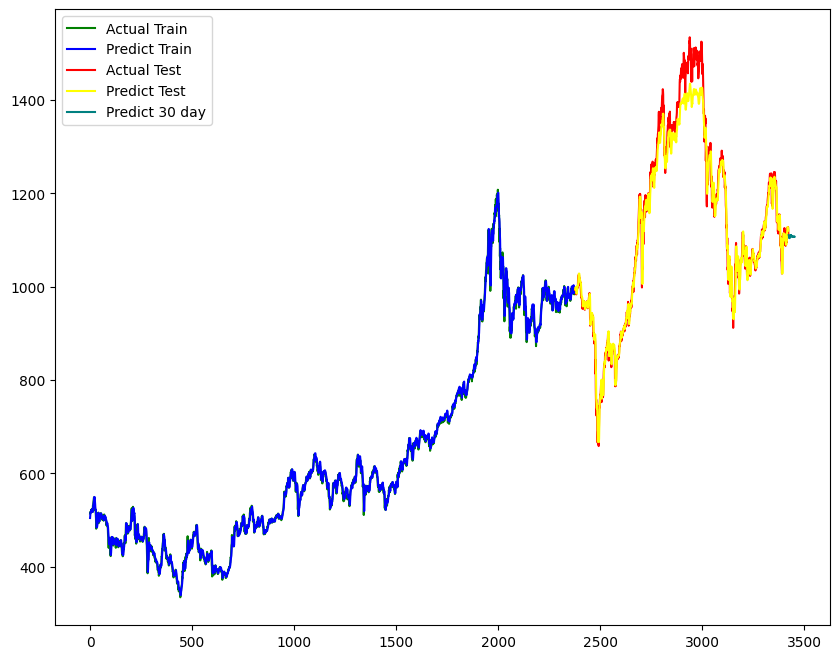

In [46]:

# Predict Next 30 days


while i < npred:
  pred = model.predict([input, np_zero])
  pred_list.append(pred)
  pred.shape
  input = np.concatenate([np.squeeze(input), pred.reshape(-1)])
  input = input[1:61].reshape((1, 60))
  i += 1

pred_list = np.array(pred_list)
pred_list = scaler.inverse_transform(pred_list.reshape(1, -1))


plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(np.squeeze(y_true_train)))
plt.plot([*train_range], np.squeeze(y_true_train), label="Actual Train", color = 'green')
plt.plot([*train_range], np.squeeze(pred_train), label="Predict Train", color ='blue')

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(np.squeeze(y_true_test)))
plt.plot([*test_range], np.squeeze(y_true_test), label="Actual Test", color='red')
plt.plot([*test_range], np.squeeze(pred_test), label="Predict Test", color='yellow')

pre_range = range(test_range[-1] +1, test_range[-1] +1 + 30)
# 30 days

plt.plot([*pre_range], np.squeeze(pred_list), label="Predict 30 day", color='teal')

plt.legend()
plt.show()

In [47]:
def create_weekdays_december_january_dataframe():
    start_date = datetime(2023, 12, 16)
    end_date = datetime(2024, 1, 31)
    date_range = pd.date_range(start_date, end_date)
    df = pd.DataFrame({"Date": date_range})
    df = df[(df["Date"].dt.dayofweek != 5) & (df["Date"].dt.dayofweek != 6)]
    new_df = pd.DataFrame({"Date": df["Date"].dt.strftime('%Y-%m-%d')})
    new_df = new_df.head(30)
    return new_df

In [48]:
date_pre = create_weekdays_december_january_dataframe()
future_30_days_df = pd.DataFrame(np.squeeze(pred_list), index=date_pre["Date"], columns=["Open"])
future_30_days_df.index = pd.to_datetime(future_30_days_df.index)
future_30_days_df

,Open
Date,
2023-12-18,1110.486938
2023-12-19,1108.894897
2023-12-20,1105.021973
2023-12-21,1105.580688
2023-12-22,1103.917114
2023-12-25,1105.976318
2023-12-26,1105.638672
2023-12-27,1108.043701
2023-12-28,1107.869141
